In [5]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


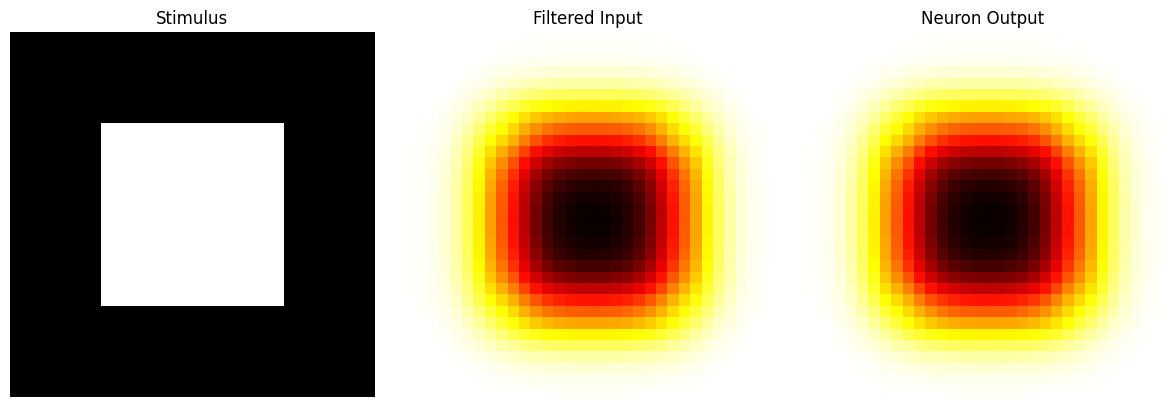

In [ ]:
# create a retina stimulus 
def create_stimulus(size=32):
    stim = np.zeros((size, size))
    stim[size//4:3*size//4, size//4:3*size//4] = 1.0  # Bright square
    return stim

# create a centre surround filter
def centre_surround(centre_sigma=1, surround_sigma=3, strength=1):
    size = 21
    x = np.linspace(-size//2, size//2, size)
    X, Y = np.meshgrid(x, x)
    centre = np.exp(-(X**2 + Y**2) / (2 * centre_sigma**2))
    surround = np.exp(-(X**2 + Y**2) / (2 * surround_sigma**2))
    return centre - strength * surround

stimulus = create_stimulus()
kernel = centre_surround()
convolved = convolve(stimulus, kernel, mode='reflect').flatten()

start_scope()
N = stimulus.size
tau = 10*ms
threshold = 0.2

eqs = '''
dv/dt = (-v + input_current) / tau : 1
input_current : 1
'''

neurons = NeuronGroup(N, eqs, threshold='v > 1', reset='v = 0', method='euler')
neurons.input_current = convolved
mon = StateMonitor(neurons, 'v', record=True)

run(100*ms)

output = mon.v[:, -1].reshape(stimulus.shape)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Stimulus")
plt.imshow(stimulus, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Filtered Input")
plt.imshow(convolved.reshape(stimulus.shape), cmap='hot')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Neuron Output")
plt.imshow(output, cmap='hot')
plt.axis('off')
plt.tight_layout()
plt.show()
